#Group Assignment, Recommendation Engines

Group 2 

MBD, IE School of Human Sciences & Technology


## Environment setup

In [ ]:
install.packages(c('dplyr','ggplot2','knitr','recommenderlab'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppProgress’, ‘arules’, ‘proxy’, ‘registry’, ‘irlba’, ‘recosystem’




In [ ]:
library(dplyr)
library(ggplot2)
library(knitr)
library(recommenderlab)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: arules


Attaching package: ‘arules’


The following object is masked from ‘package:dplyr’:

    recode


The following objects are masked from ‘package:base’:

    abbreviate, write


Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:Matrix’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: registry

Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



#Similarities 

In our previous session we covered how to measure similarities among users or items. In this section we are going to put that in practice, using the functions provided by recommenderlab.

In [ ]:
data(MovieLense)

In [ ]:
## we use set.seed to get exactly the same 50 users. 
#Seed is the seed used by pseudorandom number generator, widely used to make experiment reproducible 
set.seed(1)

## let's get a sample with 10 user who have rate at least 410 movies, that will ease make comparison
my_sample <- sample(MovieLense[rowCounts(MovieLense) > 410,], 10)

In [ ]:
my_sample

10 x 1664 rating matrix of class ‘realRatingMatrix’ with 5117 ratings.

In [ ]:
my_sample@data[1:10, 1:10]

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                       
416 5 4 . 4 . . 4 5 5 3
276 5 4 3 4 3 . 5 4 5 .
393 3 4 3 4 3 . 4 3 4 .
13  3 3 . 5 1 . 2 4 3 .
181 3 . 2 . . 1 4 . 4 2
279 3 4 . 4 . . 5 . . 4
450 4 4 4 3 . . 4 . . 4
234 3 2 . 4 3 . 2 5 3 3
655 2 3 . 2 2 4 3 3 3 .
303 5 3 3 4 2 . 4 5 5 .

In [ ]:
options(repr.plot.width=15, repr.plot.height=8)

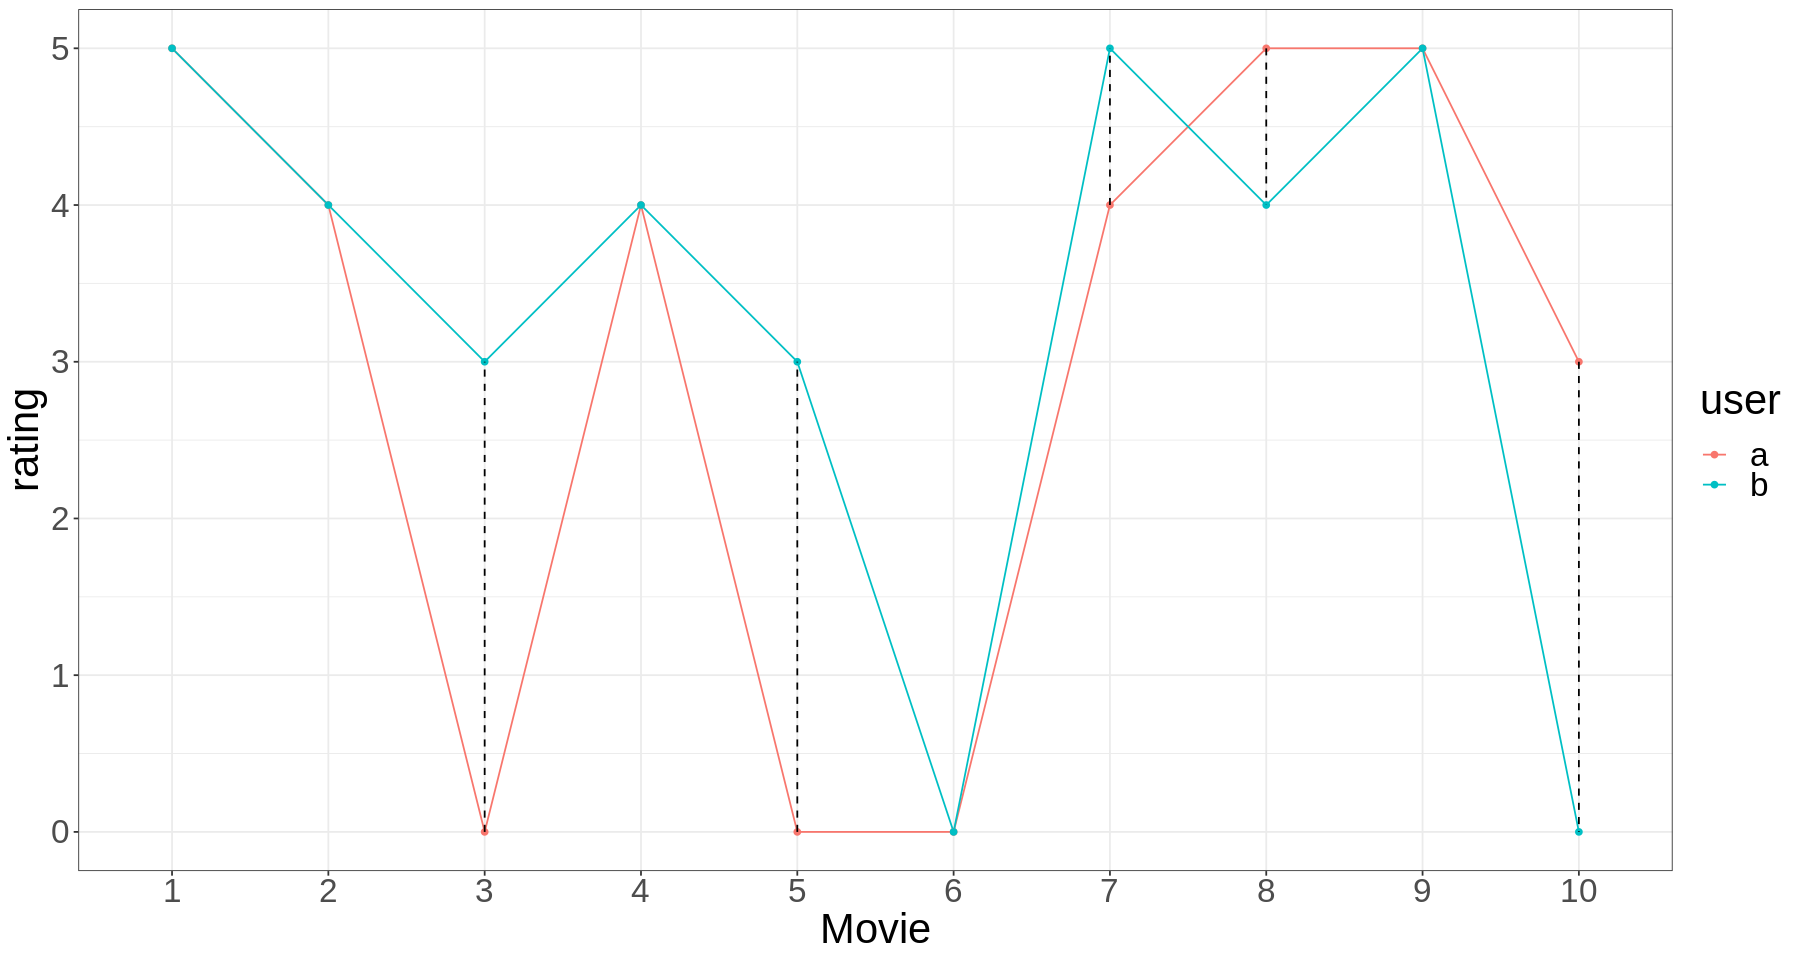

In [ ]:
first_movie =1
last_movie=10
num_movies= last_movie-first_movie+1
user_a <- my_sample@data[1,first_movie:last_movie ]
user_b <- my_sample@data[2,first_movie:last_movie ]

data <- data.frame(user = rep(c("a", "b"), each =num_movies ),
rating = c(user_a,user_b),item = first_movie:last_movie)
ggplot(data = data, aes(x = as.factor(item), y = rating, colour = user)) +
geom_path(aes(group = user)) +
geom_point() +
geom_line(aes(group=item), colour="black", linetype="dashed")+
labs(x = "Movie") +
theme_bw() +
theme(text = element_text(size = 25), legend.position = "right")  


In [ ]:
normalized_sample <-normalize(my_sample[1:2,1:10])
normalized_sample@data

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



2 x 10 sparse Matrix of class "dgCMatrix"
                                                                         
416 0.7142857 -0.2857143  .     -0.2857143  .     . -0.2857143  0.7142857
276 0.8750000 -0.1250000 -1.125 -0.1250000 -1.125 .  0.8750000 -0.1250000
                       
416 0.7142857 -1.285714
276 0.8750000  .       

Let's plot both date normalized and denormalized

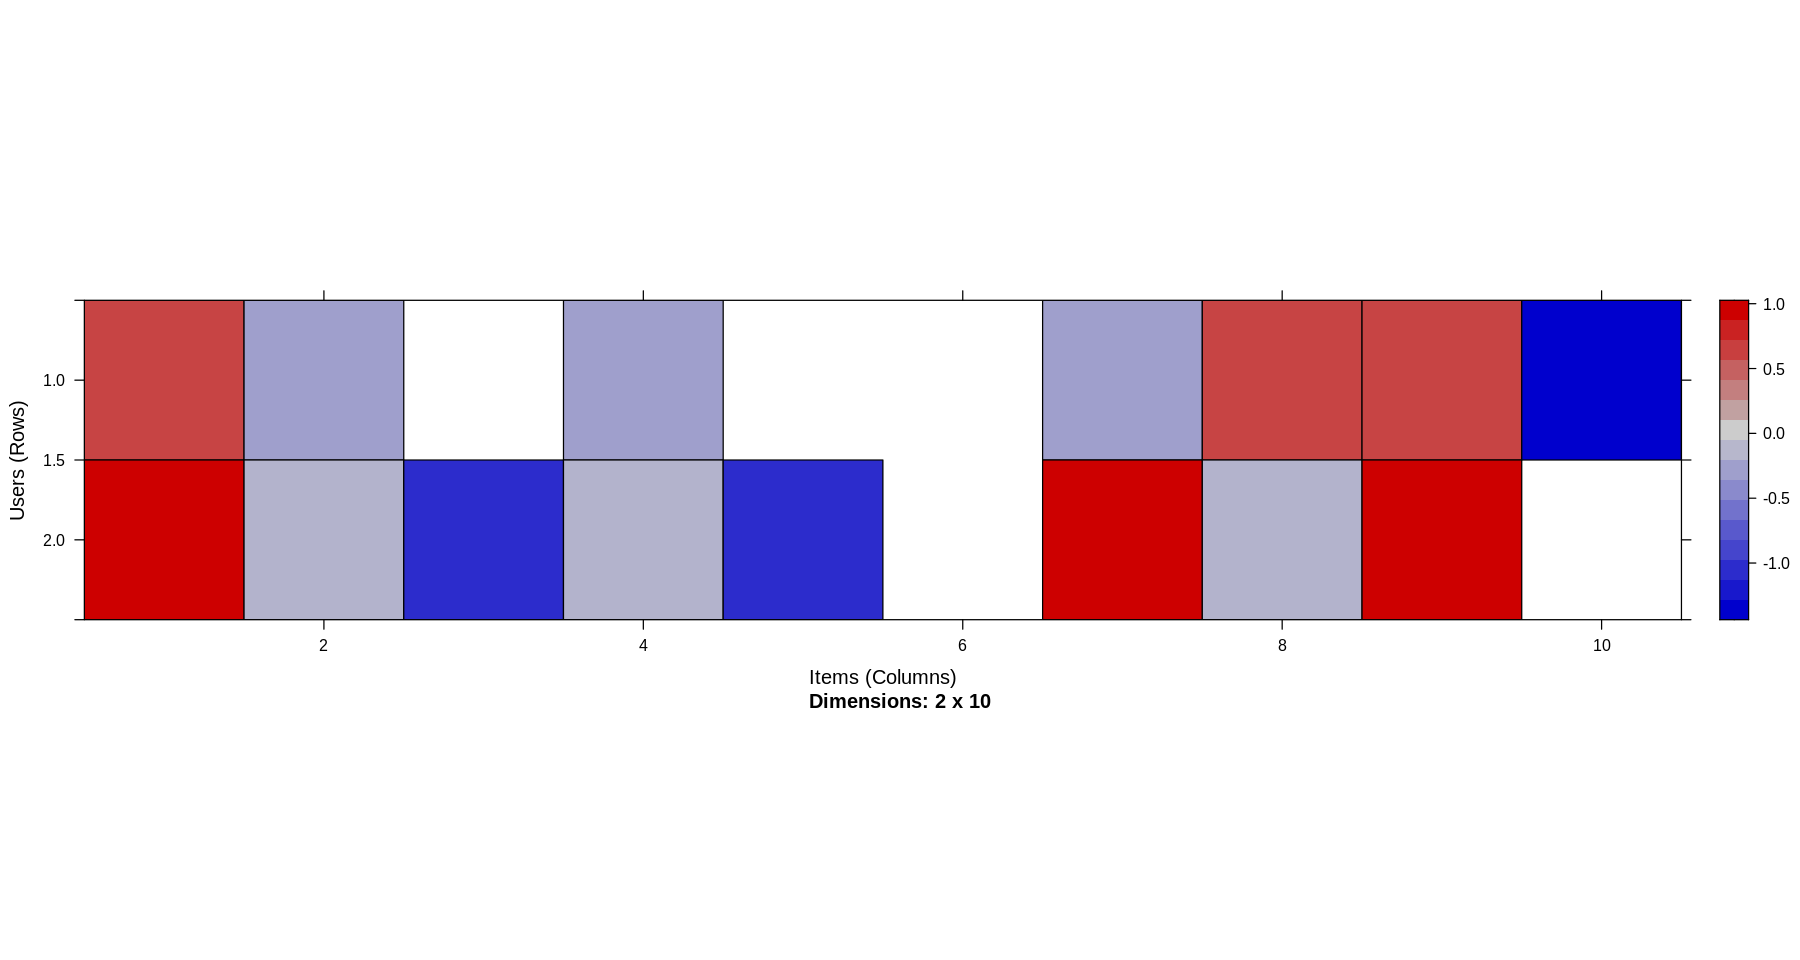

In [ ]:
image(normalized_sample)

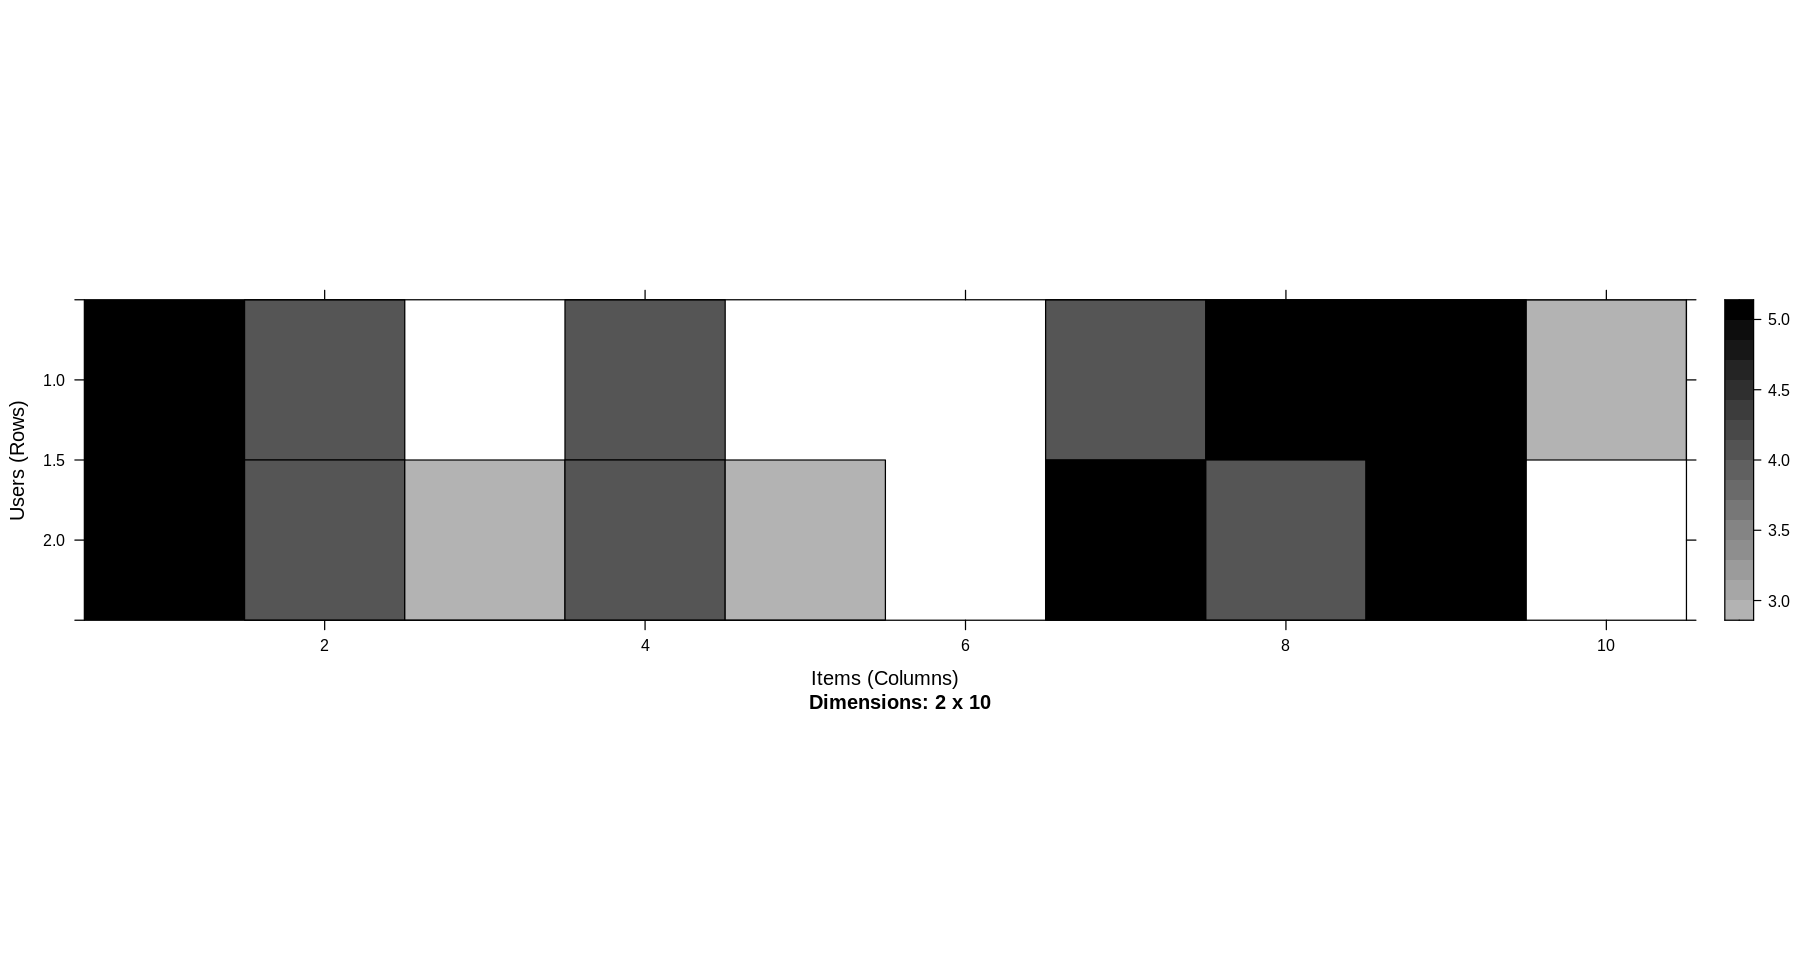

In [ ]:
image(denormalize(normalized_sample))

## Exercise 1 (1 points)
Please normalize the rating of user A and B and then plot a graph like we plotted below



```
user_a <- my_sample@data[1,first_movie:last_movie ]
user_b <- my_sample@data[2,first_movie:last_movie ]

data <- data.frame(user = rep(c("a", "b"), each =num_movies ),
rating = c(user_a,user_b),item = first_movie:last_movie)
ggplot(data = data, aes(x = as.factor(item), y = rating, colour = user)) +
geom_path(aes(group = user)) +
geom_point() +
geom_line(aes(group=item), colour="black", linetype="dashed")+
labs(x = "Movie") +
theme_bw() +
theme(text = element_text(size = 25), legend.position = "right")  
```
Instead of user_a and user_b create the variables user_a_normalized and user_b_normalized and make the required changes in code. 


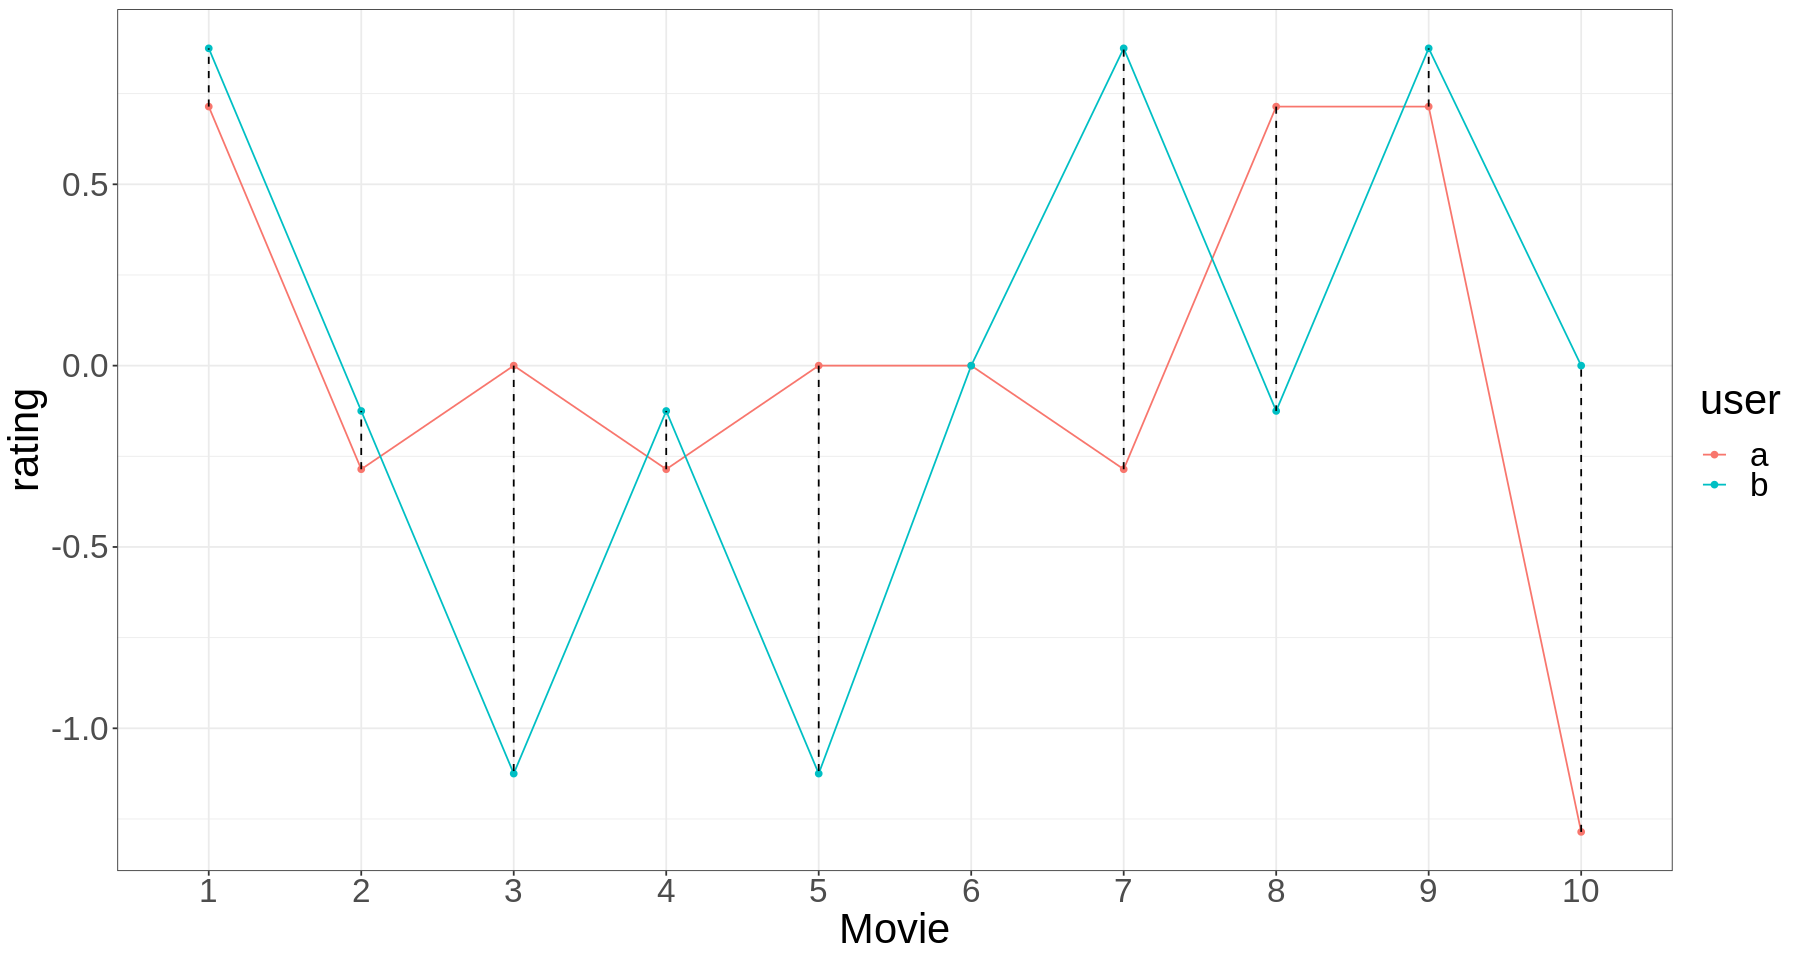

In [ ]:
## INSERT YOUR CODE HERE
user_a_normalized <- normalized_sample@data[1,first_movie:last_movie ]
user_b_normalized <- normalized_sample@data[2,first_movie:last_movie ]
 
data <- data.frame(user = rep(c("a", "b"), each =num_movies ),
rating = c(user_a_normalized, user_b_normalized),item = first_movie:last_movie)
ggplot(data = data, aes(x = as.factor(item), y = rating, colour = user)) +
geom_path(aes(group = user)) +
geom_point() +
geom_line(aes(group=item), colour="black", linetype="dashed")+
labs(x = "Movie") +
theme_bw() +
theme(text = element_text(size = 25), legend.position = "right")

Let's compute the similarity between user_a and user_b using the adjusted cosine similarity

\begin{equation}
sim(i,j) = \dfrac{\sum\limits_{u\in U}(R_{u,i} - \overline{R_i})(R_{u,j}-\overline{R_j})}
{\sqrt{\sum\limits_{u \in U} (R_{u,i}- \overline{R_i})^2 \sum\limits_{u\in U} (R_{u,j} - \overline{R_j})^2}}
\end{equation}

In [ ]:
similarity(normalize(my_sample[1:2,1:10]), method ="cosine",  which = "users", min_matching=1)

          416
276 0.4814569

In [ ]:
normalize(my_sample[1:2,1:10])@data

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



2 x 10 sparse Matrix of class "dgCMatrix"
                                                                         
416 0.7142857 -0.2857143  .     -0.2857143  .     . -0.2857143  0.7142857
276 0.8750000 -0.1250000 -1.125 -0.1250000 -1.125 .  0.8750000 -0.1250000
                       
416 0.7142857 -1.285714
276 0.8750000  .       

Let's compute the adjusted cosine similarity manually 

In [ ]:
a_norm<-c(0.7142857, -0.2857143,  -0.2857143,-0.2857143,  0.7142857, 0.7142857 ) 
b_norm<-c(0.8750000, -0.1250000, -0.1250000, 0.8750000 ,-0.1250000 ,0.8750000  ) 

In [ ]:
a_norm * b_norm

[1]  0.62499999  0.03571429  0.03571429 -0.25000001 -0.08928571  0.62499999

In [ ]:
sum(a_norm * b_norm) / ( sqrt(sum(a_norm*a_norm)) * sqrt(sum(b_norm*b_norm)) )

[1] 0.4814569

## Exercise 2 (0.5 points)

Please compute the cosine similarity with the ratings of user 276 and 416, who are stored in positions 1 and 2 of my_sample rating matrix, using the function **similarity**


In [ ]:
## INSERT YOUR CODE HERE
similarity(my_sample[1:2,1:10], method ="cosine",  which = "users", min_matching=1)

          416
276 0.9918699

## Exercise 3 (1.5 points)

Please compute the cosine similarity manually and check that the result that you obtain
 using the previous code. 

1. Create two vector with the ratings of user 276 and 416, who are stored in positions 1 and 2 of my_sample rating matrix. **Please consider only movies from 1 to 10**
2. Compute the cosine similarity using the functions sum, sqrt like we did previously 

```
sum(a_norm * b_norm) / ( sqrt(sum(a_norm*a_norm)) * sqrt(sum(b_norm*b_norm)) )
```
3. Check that obtained result is exactly the same obtained using **similiraty** function. 



In [ ]:
# get data of users 276 and 416
my_sample[1:2,1:10]@data

# get list of ratings per user
user276 <- c(5,4,4,4,5,5)
user416 <- c(5,4,4,5,4,5)

# calculate cosine similarity
cosine_sim <- (sum(user276*user416)/(sqrt(sum(user276*user276))*sqrt(sum(user416*user416))))
print(cosine_sim)

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



2 x 10 sparse Matrix of class "dgCMatrix"
                       
416 5 4 . 4 . . 4 5 5 3
276 5 4 3 4 3 . 5 4 5 .

[1] 0.9918699


## Jaccard similarity

In session 2 we saw that another similarity measure, the **Jaccard similiraty**

$jaccard(A, B) = \frac{|A \bigcap B|}{ |A\bigcup B|}$
```
my_sample@data[5:6, 1:10]

181 3 . 2 . . 1 4 . 4 2
279 3 4 . 4 . . 5 . . 4
```




In [ ]:
binary_matrix <-binarize(my_sample[5:6,1:10], minRating=1)
as(binary_matrix,"matrix")

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995)
181,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE
279,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,TRUE


In [ ]:
similarity(binary_matrix, method ="jaccard",  which = "users")

      181
279 0.375

### Exercise 4 (1 points)

In previous example first we binarize the rating matrix into 1s and 0s and then we compute the jaccard similarity, can you explain how we obtain the value of 0.375 for the Jaccard similarity beteween user 279 and 181. 

- $|A \bigcap B|$
- $|A\bigcup B|$

Hint: 3/8 = 0.375

We binarize the ratings matrix for the Jaccard similarity because we are interesed in whether or not the user watched the movies, not exactly the ratings they gave. We therefore change any ratings to True value, and those movies that have not been rated are a False value.

For user 279 and 181: 
*  we can see that there are 3 movies that both users rated (i.e. intersection between these two users’ ratings = numerator in Jaccard similarity)
*   we can also see that between the two of them, they rated a total of 8 movies in the matrix (i.e. the union of these two users' ratings = denominator in Jaccard similarity) 
* Therefore AnB = 3 , AuB = 8, and the Jaccard Similarity = |AnB|/|Aub| = 3/8 = 0.375 

## Minimum Overlap

In session 4 we saw that in order to compute similarities a minimum overlap is required, let's compute similarities using our sample.

In [ ]:
my_sample[,1:10]@data

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Four Rooms (1995)’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                       
416 5 4 . 4 . . 4 5 5 3
276 5 4 3 4 3 . 5 4 5 .
393 3 4 3 4 3 . 4 3 4 .
13  3 3 . 5 1 . 2 4 3 .
181 3 . 2 . . 1 4 . 4 2
279 3 4 . 4 . . 5 . . 4
450 4 4 4 3 . . 4 . . 4
234 3 2 . 4 3 . 2 5 3 3
655 2 3 . 2 2 4 3 3 3 .
303 5 3 3 4 2 . 4 5 5 .

In [ ]:
similarity_users <-similarity(normalize(my_sample[,1:10]), method ="cosine",  which = "users", min_matching=4)
similarity_users

           416        276        393         13        181        279
276 0.48145692                                                       
393 0.48145692 0.48038446                                            
13  0.13130643 0.16645008 0.23904572                                 
181 0.49522242 0.88189470 0.73979544         NA                      
279 0.45566119 0.00000000 0.70710678 0.31622777         NA           
450 0.03418928 0.12422363 0.41522740 0.92966968 0.10000000 0.00000000
234 0.35349586 0.25435880 0.45098150 0.60370911 0.69955860 0.38760127
655 0.06857255 0.24816039 0.33942212 0.00000000 0.43768811 0.63245553
303 0.90663966 0.77915234 0.11867817 0.55523433 0.71133103 0.49236596
           450        234        655
276                                 
393                                 
13                                  
181                                 
279                                 
450                                 
234 0.69979992                      
655 

## Exercise 5 (1 points)

Why similarity of user 13 and 181 is *NA* 

### Insert your answer here
The similarity of user 13 and 181 is NA because there is too little overlap between them. In the similarity function, we specified that the minimum matching must be 4, meaning two users must have at least 4 movies that they both rated in order to calculate similarity. From the mySample matrix we can see that users 13 and 181 only have 3 movies in common, which means they have too little ratings in common for them to have the similarity computed between them. 

# Recommendation models

The recommenderlab package contains some options for the recommendation algorithm. We can display the model applicable to the realRatingMatrix objects using recommenderRegistry$get_entries:

```
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
```

The recommender_models object contains some information about the models. First, let's see which models we have:
`names(recommender_models)`



In [ ]:
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
names(recommender_models)

[1] "HYBRID_realRatingMatrix"       "ALS_realRatingMatrix"         
 [3] "ALS_implicit_realRatingMatrix" "IBCF_realRatingMatrix"        
 [5] "LIBMF_realRatingMatrix"        "POPULAR_realRatingMatrix"     
 [7] "RANDOM_realRatingMatrix"       "RERECOMMEND_realRatingMatrix" 
 [9] "SVD_realRatingMatrix"          "SVDF_realRatingMatrix"        
[11] "UBCF_realRatingMatrix"

In [ ]:
lapply(recommender_models, "[[", "description")

$HYBRID_realRatingMatrix
[1] "Hybrid recommender that aggegates several recommendation strategies using weighted averages."

$ALS_realRatingMatrix
[1] "Recommender for explicit ratings based on latent factors, calculated by alternating least squares algorithm."

$ALS_implicit_realRatingMatrix
[1] "Recommender for implicit data based on latent factors, calculated by alternating least squares algorithm."

$IBCF_realRatingMatrix
[1] "Recommender based on item-based collaborative filtering."

$LIBMF_realRatingMatrix
[1] "Matrix factorization with LIBMF via package recosystem (https://cran.r-project.org/web/packages/recosystem/vignettes/introduction.html)."

$POPULAR_realRatingMatrix
[1] "Recommender based on item popularity."

$RANDOM_realRatingMatrix
[1] "Produce random recommendations (real ratings)."

$RERECOMMEND_realRatingMatrix
[1] "Re-recommends highly rated items (real ratings)."

$SVD_realRatingMatrix
[1] "Recommender based on SVD approximation with column-mean imputation."

$SVDF_realRatingMatrix
[1] "Recommender based on Funk SVD with gradient descend (https://sifter.org/~simon/journal/20061211.html)."

$UBCF_realRatingMatrix
[1] "Recommender based on user-based collaborative filtering."

## Item-based collaborative filtering


We will build the model using a part of the MovieLense dataset (the training set) and apply it on the other part (the test set). Since it's not a topic of this session , we will not evaluate the model, but will only recommend movies to the users in the test set.

The two sets are as follows:
- Training set: This set includes users from which the model learns.
- Test set: This set includes users to whom we recommend movies.

The algorithm automatically normalizes the data, so we can use ratings_movies that contains relevant users and movies of MovieLense. We defined ratings_movies as the subset of MovieLense users who have rated at least 50 movies and movies that have been rated at least 100 times.


In [ ]:
ratings_movies <- MovieLense[rowCounts(MovieLense) >= 50,colCounts(MovieLense) >= 100]
ratings_movies

565 x 336 rating matrix of class ‘realRatingMatrix’ with 55832 ratings.

### Training and test dataset
First, we randomly define the which_train vector that is TRUE for users in the training set and FALSE for the others. We will set the probability in the training
set as 80 percent.

In [ ]:
set.seed(123)
which_train <- sample(x = c(TRUE, FALSE), size = nrow(ratings_movies), replace = TRUE, prob = c(0.8, 0.2))
head(which_train,10)

[1]  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE

In [ ]:
recc_data_train <- ratings_movies[which_train, ]
recc_data_test <- ratings_movies[!which_train, ]

In [ ]:
recc_data_train@data[1:10,1:10]

   [[ suppressing 10 column names ‘Toy Story (1995)’, ‘GoldenEye (1995)’, ‘Get Shorty (1995)’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                      
1  5 3 3 4 1 5 2 5 5 5
2  4 . . . . . . . 4 4
3  . . . . . . . . . .
7  . . 5 5 5 5 3 5 . .
8  . . . 3 . . 3 . . .
11 . . . . 4 5 2 2 . .
12 . . 5 . . . . . . .
14 . . . 5 . 4 . 5 4 3
15 1 . . 1 . 4 . . 1 4
16 5 . 5 5 5 5 5 5 . .

The function to build models is recommender and its inputs are as follows:
- Data: This is the training set
- Method: This is the name of the technique
- Parameters: These are some optional parameters of the technique

In [ ]:
recommenderRegistry$get_entry("IBCF", dataType="realRatingMatrix")

Recommender method: IBCF for realRatingMatrix
Description: Recommender based on item-based collaborative filtering.
Reference: NA
Parameters:
   k   method normalize normalize_sim_matrix alpha na_as_zero
1 30 "Cosine"  "center"                FALSE   0.5      FALSE

In [ ]:
recc_model_ibcf <- Recommender(data = recc_data_train, method = "IBCF",
parameter = list(k = 30))

In [ ]:
recc_model_ibcf

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 456 users.

The recc_model class is an object of the `Recommender` class containing the model

In [ ]:
class(recc_model_ibcf)

[1] "Recommender"
attr(,"package")
[1] "recommenderlab"

In [ ]:
model_details <- getModel(recc_model_ibcf)
model_details$description
dim(model_details$sim)

[1] "IBCF: Reduced similarity matrix"

[1] 336 336

As expected, model_details$sim is a square matrix whose size is equal to the number of items. We can explore a part of it using image.

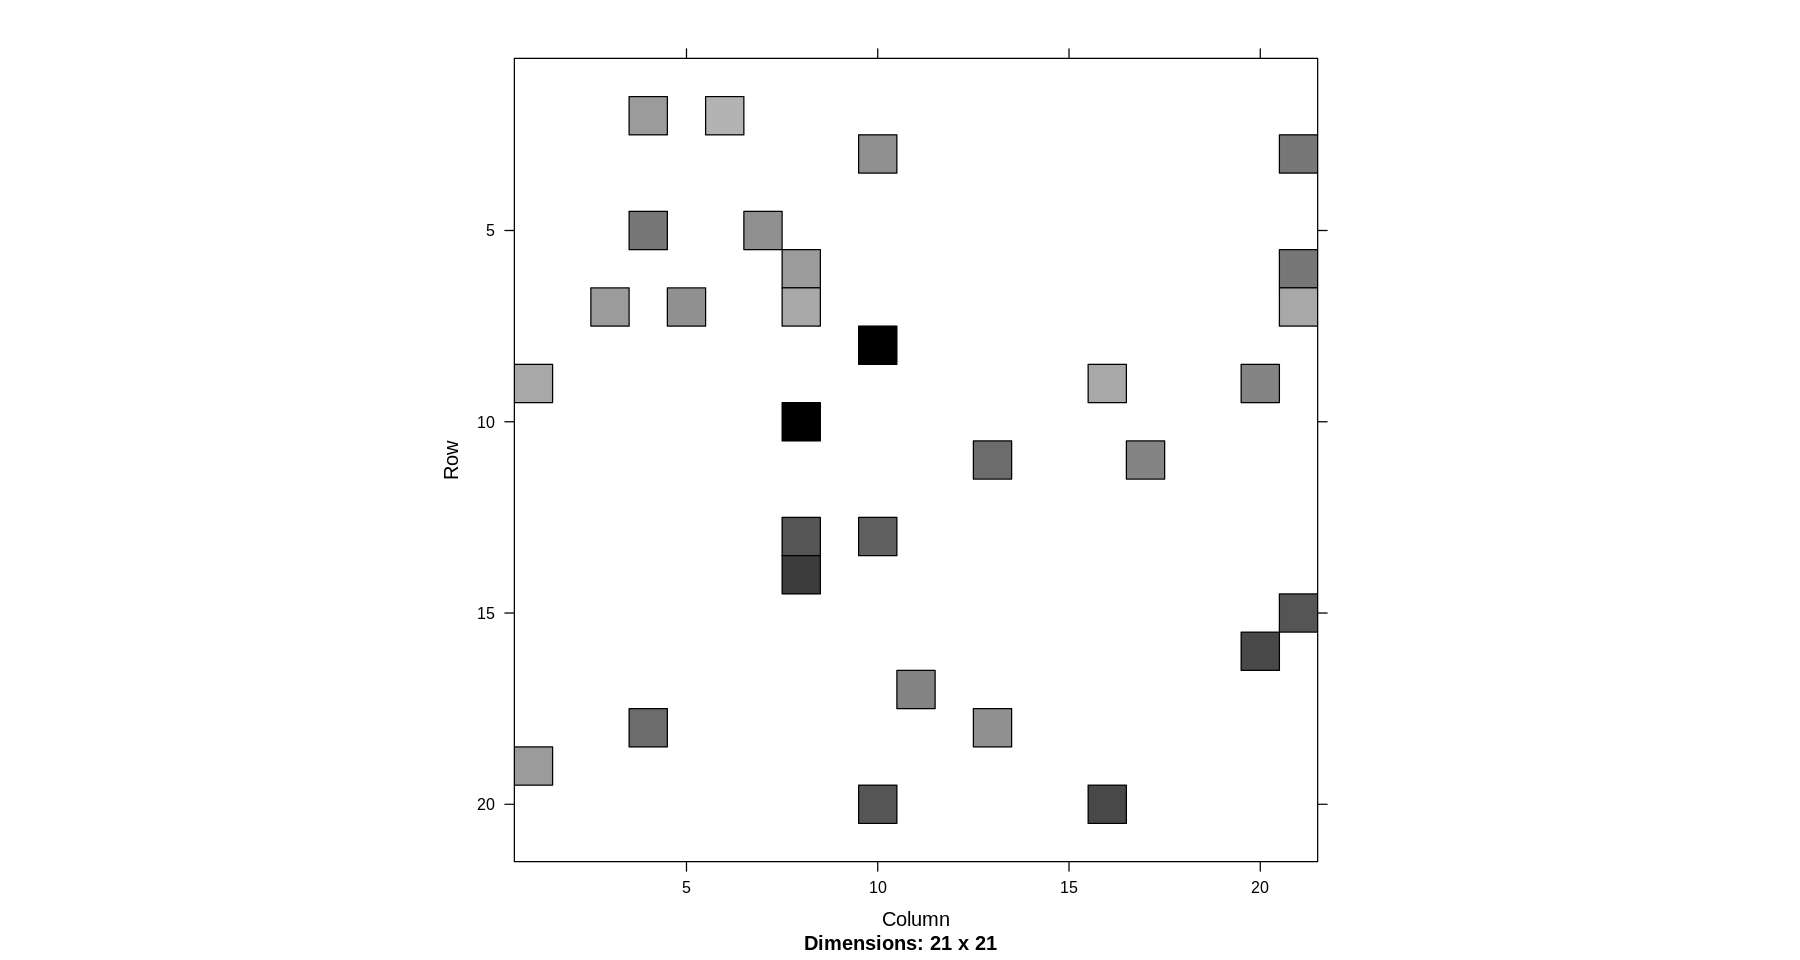

In [ ]:
image (model_details$sim[10:30,10:30])

Most of the values are equal to 0. The reason is that each row contains only k elements. Let's check it:

In [ ]:
row_sums <- rowSums(model_details$sim > 0)
table(row_sums)

row_sums
 30 
336 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



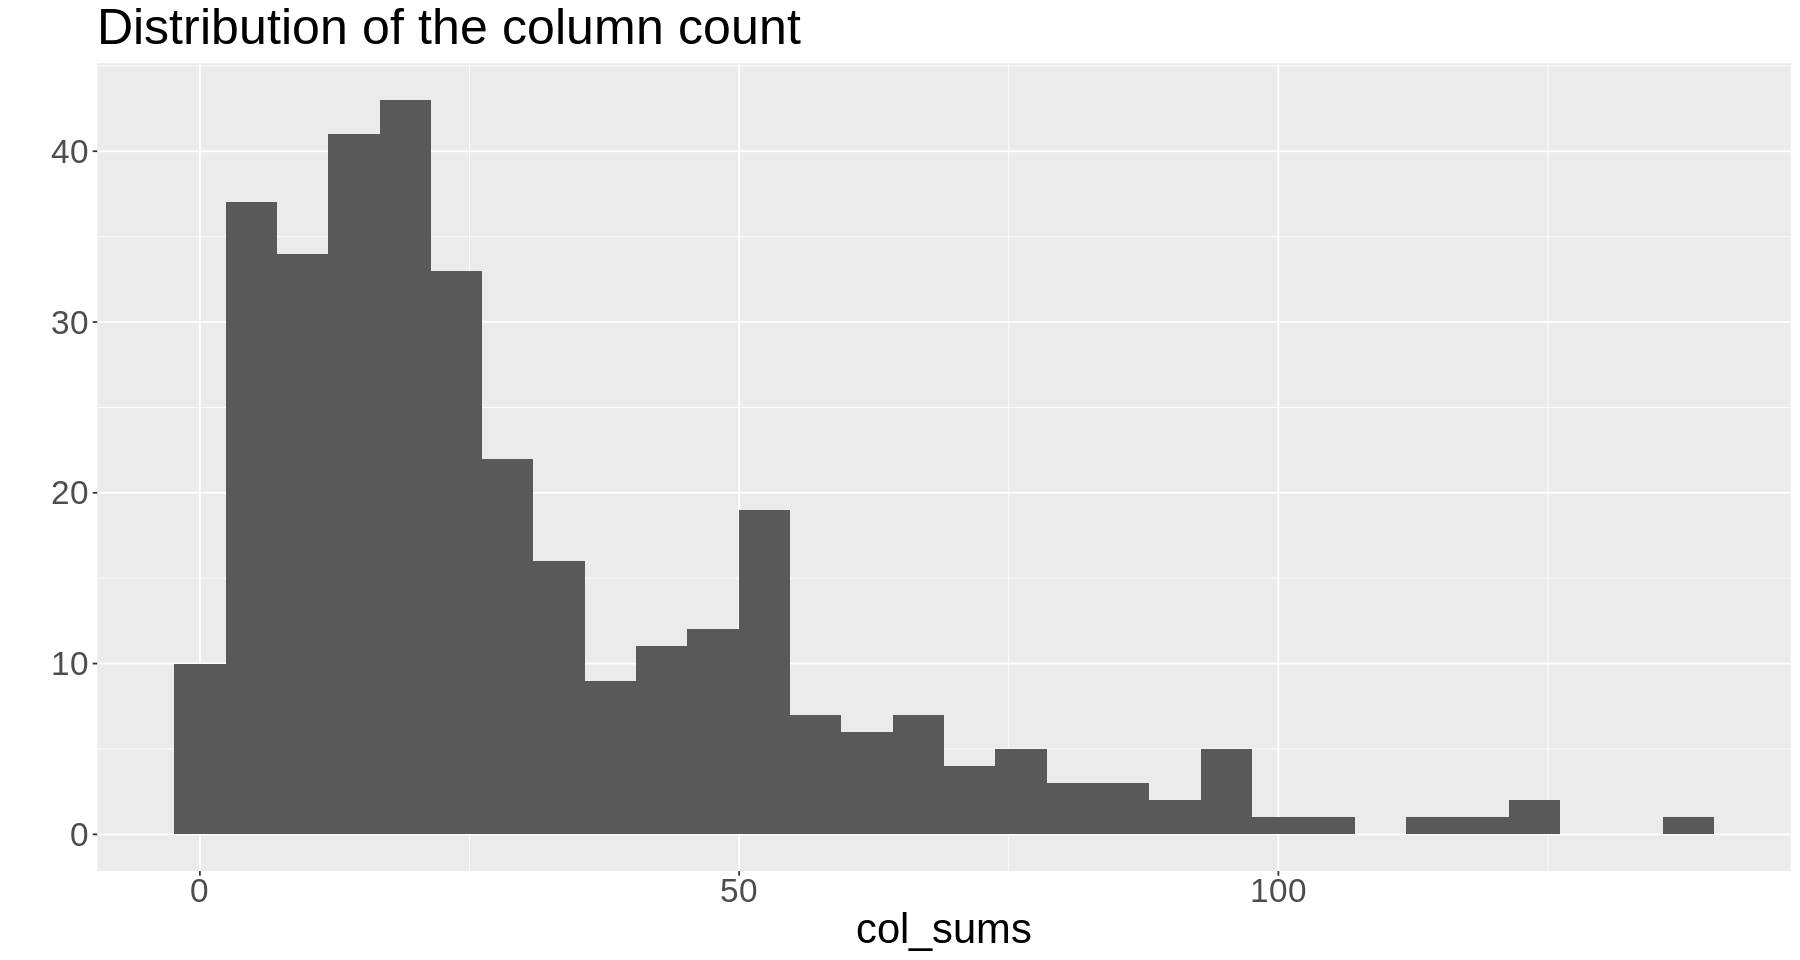

In [ ]:
col_sums <- colSums(model_details$sim > 0)
qplot(col_sums) + 
ggtitle("Distribution of the column count")+theme(text = element_text(size = 25), legend.position = "right")  

In [ ]:
which_max <- order(col_sums, decreasing = TRUE)[1:6]
rownames(model_details$sim)[which_max]

[1] "I Know What You Did Last Summer (1997)"
[2] "Jungle2Jungle (1997)"                  
[3] "Mimic (1997)"                          
[4] "Close Shave, A (1995)"                 
[5] "Wrong Trousers, The (1993)"            
[6] "Spawn (1997)"

In [ ]:
rownames(model_details$sim)[which_max]

[1] "I Know What You Did Last Summer (1997)"
[2] "Jungle2Jungle (1997)"                  
[3] "Mimic (1997)"                          
[4] "Close Shave, A (1995)"                 
[5] "Wrong Trousers, The (1993)"            
[6] "Spawn (1997)"

Now, we are able to recommend movies to the users in the test set. We will define n_recommended that specifies the number of items to recommend to each user. This section will show you the most popular approach to computing a weighted sum:

- ``` n_recommended <- 6```

For each user, the algorithm extracts its rated movies. For each movie, it identifies all its similar items, starting from the similarity matrix. Then, the algorithm ranks each
similar item in this way:
- Extract the user rating associated with this item. The rating is used as a weight.
- Extract the similarity of the item with each rating associated with this item.
- Multiply each weight with the related similarity.
- Sum everything up.

Then, the algorithm identifies the top n recommendations:


```
recc_predicted <- predict(object = recc_model, newdata = recc_data_test, n = n_recommended)
recc_predicted
```

In [ ]:
n_recommended  <- 6
recc_predicted <- predict(object = recc_model_ibcf, newdata = recc_data_test, n = n_recommended)
recc_predicted

Recommendations as ‘topNList’ with n = 6 for 109 users. 

The recc_predicted object contains the recommendations. Let's take a look at its structure:

```
class(recc_predicted)
## [1] "topNList"
## attr(,"package")
## [1] "recommenderlab"
slotNames(recc_predicted)
## [1] "items" "itemLabels" "n"
```

The slots are:
- items: This is the list with the indices of the recommended items for each user
- itemLabels: This is the name of the items
- n: This is the number of recommendations

In [ ]:
recc_predicted@items[[1]]

[1]  27 179 277  68 298 135

In [ ]:
recc_user_1 <- recc_predicted@items[[1]]
movies_user_1 <- recc_predicted@itemLabels[recc_user_1]
movies_user_1

[1] "Pulp Fiction (1994)"              "Time to Kill, A (1996)"          
[3] "Ben-Hur (1959)"                   "Phenomenon (1996)"               
[5] "Manchurian Candidate, The (1962)" "Cape Fear (1991)"

In [ ]:
df <- data.frame(recc_user_1,movies_user_1)
names(df) <- c("item_idx","item_label")
df

item_idx,item_label
<int>,<chr>
27,Pulp Fiction (1994)
179,"Time to Kill, A (1996)"
277,Ben-Hur (1959)
68,Phenomenon (1996)
298,"Manchurian Candidate, The (1962)"
135,Cape Fear (1991)


In [ ]:
recc_matrix <- sapply(recc_predicted@items, function(x){
colnames(ratings_movies)[x]
})
recc_matrix [ ,1:10]

5,6,10,13,21,25,26,38,52,54
Pulp Fiction (1994),Rear Window (1954),Stargate (1994),"Frighteners, The (1996)","Firm, The (1993)",Hoop Dreams (1994),"Lion King, The (1994)",Twelve Monkeys (1995),"Net, The (1995)","Truth About Cats & Dogs, The (1996)"
"Time to Kill, A (1996)","Devil's Advocate, The (1997)",Mrs. Doubtfire (1993),"Firm, The (1993)","Devil's Advocate, The (1997)","Fish Called Wanda, A (1988)","Close Shave, A (1995)",Seven (Se7en) (1995),Natural Born Killers (1994),"Blues Brothers, The (1980)"
Ben-Hur (1959),Broken Arrow (1996),"Godfather: Part II, The (1974)",Tin Cup (1996),Tin Cup (1996),Cinema Paradiso (1988),"Craft, The (1996)",Crimson Tide (1995),Outbreak (1995),Grosse Pointe Blank (1997)
Phenomenon (1996),G.I. Jane (1997),Swingers (1996),Con Air (1997),Beauty and the Beast (1991),Sling Blade (1996),"Abyss, The (1989)","Net, The (1995)",While You Were Sleeping (1995),"Hunchback of Notre Dame, The (1996)"
"Manchurian Candidate, The (1962)",Starship Troopers (1997),Mr. Smith Goes to Washington (1939),Crash (1996),Jerry Maguire (1996),Leaving Las Vegas (1995),Sneakers (1992),Reservoir Dogs (1992),Ace Ventura: Pet Detective (1994),I Know What You Did Last Summer (1997)
Cape Fear (1991),Pretty Woman (1990),Die Hard: With a Vengeance (1995),"Time to Kill, A (1996)",Welcome to the Dollhouse (1995),Harold and Maude (1971),Ace Ventura: Pet Detective (1994),Platoon (1986),"Mask, The (1994)",Speed (1994)


### Exercise 6 (0.5 points)

In previous example we got the recommendations using the dataset `recc_data_test` obtaining the top-n recommendation for the first user in the dataset

**What is the id of that user?**

In [ ]:
users <- as.numeric(rownames(recc_data_test@data[1:10,1:10]))
users[1]

[1] 5

### Insert your answer here

The ID of the first user is 5

### Exercise 7 (1.5 points)

Create a recommender system using a neighbourhood size of 35 and providing for each user the top-7 recommendation. 

- Train recommender system (1.0 point)
- Get the top-7 recommendation for first user in `recc_data_test` (0.5 points)

In [ ]:
### Insert your code here
set.seed(123)

# train the recommender system
recc_model_ibcf <- Recommender(data = recc_data_train, method = "IBCF", parameter = list(k = 35))
recc_model_ibcf

# predict top-7 movies for each user in the test set
n_recommended  <- 7
recc_predicted <- predict(object = recc_model_ibcf, newdata = recc_data_test, n = n_recommended)

# print out the top 7 mosvies for the first user in the test set
print("Top 7 recommendations for first user in test set: ")
recc_user_1 <- recc_predicted@items[[1]]
movies_user_1 <- recc_predicted@itemLabels[recc_user_1]
movies_user_1

Recommender of type ‘IBCF’ for ‘realRatingMatrix’ 
learned using 456 users.

[1] "Top 7 recommendations for first user in test set: "


[1] "Time to Kill, A (1996)"          "Ben-Hur (1959)"                 
[3] "Army of Darkness (1993)"         "Maverick (1994)"                
[5] "My Best Friend's Wedding (1997)" "Net, The (1995)"                
[7] "Brazil (1985)"

In [ ]:
recc_matrix <- sapply(recc_predicted@items, function(x){
colnames(ratings_movies)[x]
})
recc_matrix [ ,1:10]

5,6,10,13,21,25,26,38,52,54
"Time to Kill, A (1996)",Rear Window (1954),Swingers (1996),Con Air (1997),"Firm, The (1993)",Hoop Dreams (1994),"Craft, The (1996)",Twelve Monkeys (1995),"Net, The (1995)","Truth About Cats & Dogs, The (1996)"
Ben-Hur (1959),Broken Arrow (1996),Mrs. Doubtfire (1993),"Frighteners, The (1996)","Devil's Advocate, The (1997)","Fish Called Wanda, A (1988)","Close Shave, A (1995)",Seven (Se7en) (1995),Natural Born Killers (1994),"Blues Brothers, The (1980)"
Army of Darkness (1993),Primal Fear (1996),Mr. Smith Goes to Washington (1939),"Firm, The (1993)",Beauty and the Beast (1991),Cinema Paradiso (1988),Ace Ventura: Pet Detective (1994),Crimson Tide (1995),Outbreak (1995),Grosse Pointe Blank (1997)
Maverick (1994),Independence Day (ID4) (1996),"Princess Bride, The (1987)",Crash (1996),Jerry Maguire (1996),Patton (1970),"Lion King, The (1994)","Net, The (1995)",While You Were Sleeping (1995),I Know What You Did Last Summer (1997)
My Best Friend's Wedding (1997),My Best Friend's Wedding (1997),Stargate (1994),"Time to Kill, A (1996)",Tin Cup (1996),Sling Blade (1996),"Abyss, The (1989)",Platoon (1986),"Mask, The (1994)",Arsenic and Old Lace (1944)
"Net, The (1995)",Absolute Power (1997),Die Hard: With a Vengeance (1995),Tin Cup (1996),Apocalypse Now (1979),Leaving Las Vegas (1995),Ghost (1990),Monty Python and the Holy Grail (1974),Blade Runner (1982),Speed (1994)
Brazil (1985),"Manchurian Candidate, The (1962)",Die Hard 2 (1990),"Lost World: Jurassic Park, The (1997)",Cold Comfort Farm (1995),Harold and Maude (1971),Spawn (1997),Field of Dreams (1989),Mystery Science Theater 3000: The Movie (1996),Gattaca (1997)


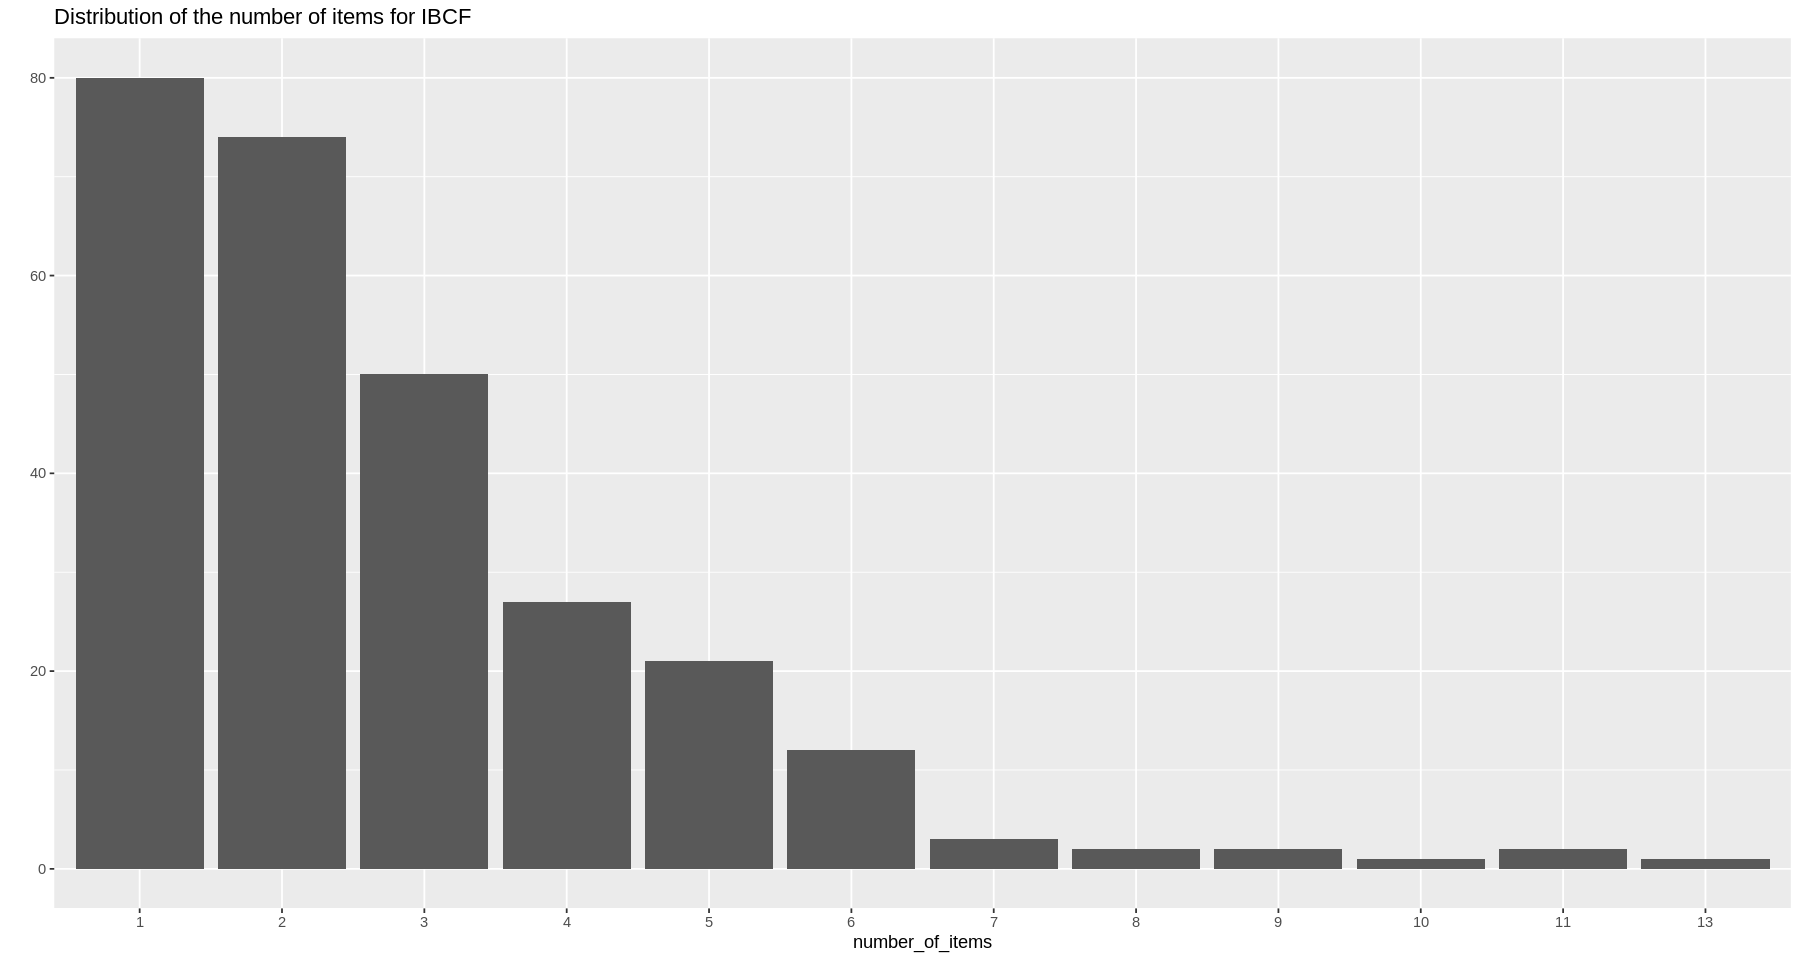

In [ ]:
number_of_items <- factor(table(recc_matrix))
chart_title <- "Distribution of the number of items for IBCF"
qplot(number_of_items) + ggtitle(chart_title)

In [ ]:
number_of_items_sorted <- sort(number_of_items, decreasing = TRUE)
number_of_items_top <- head(number_of_items_sorted, n = 6)
table_top <- data.frame(names(number_of_items_top),
number_of_items_top)
table_top

,names.number_of_items_top.,number_of_items_top
,<chr>,<fct>
Mystery Science Theater 3000: The Movie (1996),Mystery Science Theater 3000: The Movie (1996),13
Con Air (1997),Con Air (1997),11
"Craft, The (1996)","Craft, The (1996)",11
Spawn (1997),Spawn (1997),10
Ace Ventura: Pet Detective (1994),Ace Ventura: Pet Detective (1994),9
"Frighteners, The (1996)","Frighteners, The (1996)",9


## User-based collaborative filtering

The R command to build the model is the same as the previous chapter. Now, the technique is called UBCF:
```
recommender_models <- recommenderRegistry$get_entries(dataType ="realRatingMatrix")
recommender_models$UBCF_realRatingMatrix$parameters
```

Some relevant parameters are:
- method: This shows how to compute the similarity between users
- nn: This shows the number of similar users that are considered in order to calculate the recommendation

In [ ]:
recc_model_ubcf <- Recommender(data = recc_data_train, method = "UBCF")
recc_model_ubcf

Recommender of type ‘UBCF’ for ‘realRatingMatrix’ 
learned using 456 users.

In [ ]:
model_details <- getModel(recc_model_ubcf)
model_details

$description
[1] "UBCF-Real data: contains full or sample of data set"

$data
456 x 336 rating matrix of class ‘realRatingMatrix’ with 44424 ratings.
Normalized using center on rows.

$method
[1] "cosine"

$nn
[1] 25

$sample
[1] FALSE

$weighted
[1] TRUE

$normalize
[1] "center"

$min_matching_items
[1] 0

$min_predictive_items
[1] 0

$verbose
[1] FALSE


## Exercise 8 (1 point)

Modify `recc_model_ubcf` model to use a neighbourhood size of 15.

In [ ]:
### insert your code here
recc_model_ubcf <- Recommender(data = recc_data_train, method = "UBCF", param=list(nn=15))

## Exercise 9 (1 point)

Using a similar code like we used for IBCF, make recomendation for the test dataset, **providing 7 recommendations for each user**

```
n_recommended  <- 6
recc_predicted <- predict(object = recc_model_ibcf, newdata = recc_data_test, n = n_recommended)
recc_predicted
```

In [ ]:
# make 7 recommendations for test data set
n_recommended  <- 7
recc_predicted <- predict(object = recc_model_ibcf, newdata = recc_data_test, n = n_recommended)
recc_predicted

Recommendations as ‘topNList’ with n = 7 for 109 users. 

In [ ]:
#check it worked by checking recommendations for first user
recc_predicted@items[[1]]

# print first user recommendations by title
recc_user_1 <- recc_predicted@items[[1]]
movies_user_1 <- recc_predicted@itemLabels[recc_user_1]
movies_user_1


[1]  27 179 277  68 298 135 163

[1] "Pulp Fiction (1994)"              "Time to Kill, A (1996)"          
[3] "Ben-Hur (1959)"                   "Phenomenon (1996)"               
[5] "Manchurian Candidate, The (1962)" "Cape Fear (1991)"                
[7] "My Best Friend's Wedding (1997)"

## Exercise 10 (1 point)

Based in the previous code show the recommendation for first ten users in test dataset. 

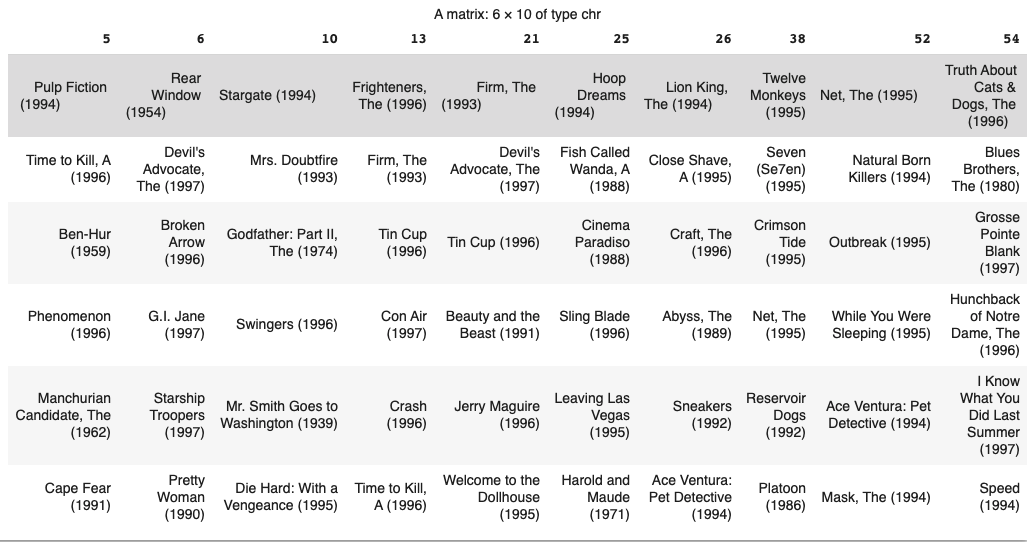


In [ ]:
recc_matrix <- sapply(recc_predicted@items, function(x){colnames(ratings_movies)[x]})
print("Recommendations for First 10 Users in the Dataset")
recc_matrix [ ,1:10]

[1] "Recommendations for First 10 Users in the Dataset"


5,6,10,13,21,25,26,38,52,54
Pulp Fiction (1994),Rear Window (1954),Stargate (1994),"Frighteners, The (1996)","Firm, The (1993)",Hoop Dreams (1994),"Lion King, The (1994)",Twelve Monkeys (1995),"Net, The (1995)","Truth About Cats & Dogs, The (1996)"
"Time to Kill, A (1996)","Devil's Advocate, The (1997)",Mrs. Doubtfire (1993),"Firm, The (1993)","Devil's Advocate, The (1997)","Fish Called Wanda, A (1988)","Close Shave, A (1995)",Seven (Se7en) (1995),Natural Born Killers (1994),"Blues Brothers, The (1980)"
Ben-Hur (1959),Broken Arrow (1996),"Godfather: Part II, The (1974)",Tin Cup (1996),Tin Cup (1996),Cinema Paradiso (1988),"Craft, The (1996)",Crimson Tide (1995),Outbreak (1995),Grosse Pointe Blank (1997)
Phenomenon (1996),G.I. Jane (1997),Swingers (1996),Con Air (1997),Beauty and the Beast (1991),Sling Blade (1996),"Abyss, The (1989)","Net, The (1995)",While You Were Sleeping (1995),"Hunchback of Notre Dame, The (1996)"
"Manchurian Candidate, The (1962)",Starship Troopers (1997),Mr. Smith Goes to Washington (1939),Crash (1996),Jerry Maguire (1996),Leaving Las Vegas (1995),Sneakers (1992),Reservoir Dogs (1992),Ace Ventura: Pet Detective (1994),I Know What You Did Last Summer (1997)
Cape Fear (1991),Pretty Woman (1990),Die Hard: With a Vengeance (1995),"Time to Kill, A (1996)",Welcome to the Dollhouse (1995),Harold and Maude (1971),Ace Ventura: Pet Detective (1994),Platoon (1986),"Mask, The (1994)",Speed (1994)
My Best Friend's Wedding (1997),Crash (1996),"Right Stuff, The (1983)","Devil's Own, The (1997)",Dave (1993),Lawrence of Arabia (1962),Welcome to the Dollhouse (1995),Monty Python and the Holy Grail (1974),Blade Runner (1982),Arsenic and Old Lace (1944)


# Bonus track

Use `evaluationScheme` method to evaluate both recommenders created during this lab. Please check the documentation and explain the parameters. 

### Explanation of EvaluateScheme Parameters
* Data = my_sample, this uses our sample data for evaluation
* Method = split, this specifies to use split (i.e. train-test) as the method of evaluation
* Train = 0.8, specifies that split uses 80% of data as training data
* Given = 3, this means that 3 items are used for evaluation
* goodRating = 3, this specifies that a rating of 3 or above is considered good/positive class

In [ ]:
# create an evaluation scheme used to evalute the different models
eval_scheme <- evaluationScheme(data = my_sample, method = "split", train = 0.8, given = 3, goodRating = 5)

### Explanation of Code Below

The code below creates a list of the models we want to evaluate. Here we are replicating the two models we have created throughout the assignment, the first being the IBCF model with a neighborhood size of 35, and the second being the UBCF model with a neighborhood size of 15. 


In [ ]:
# create a list of the recommendation systems to evaluate
models <- list(
  IBCF_recc = list(name = "IBCF", param = list(k=35)),
  UBCF_recc = list(name = "UBCF", param = list(nn=15))
)

### Explanation of Evaluate Function Parameters

* x = eval_scheme, specifies to use our previously created evaluation scheme 
* type = topNList, specifies to evaluate the topNList (instead of the ratings)
* method = models, specifies to evaluate the two models in the models list
* n = 1:20, specifies to create 1-20 recommendations for the topNList and evaluate each 

In [ ]:
# evaluate the 2 models 
eval_results <- evaluate(x = eval_scheme, type="topNList", method = models, n=1:7)

IBCF run fold/sample [model time/prediction time]
	 1  [0.543sec/0.008sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.002sec/0.014sec] 


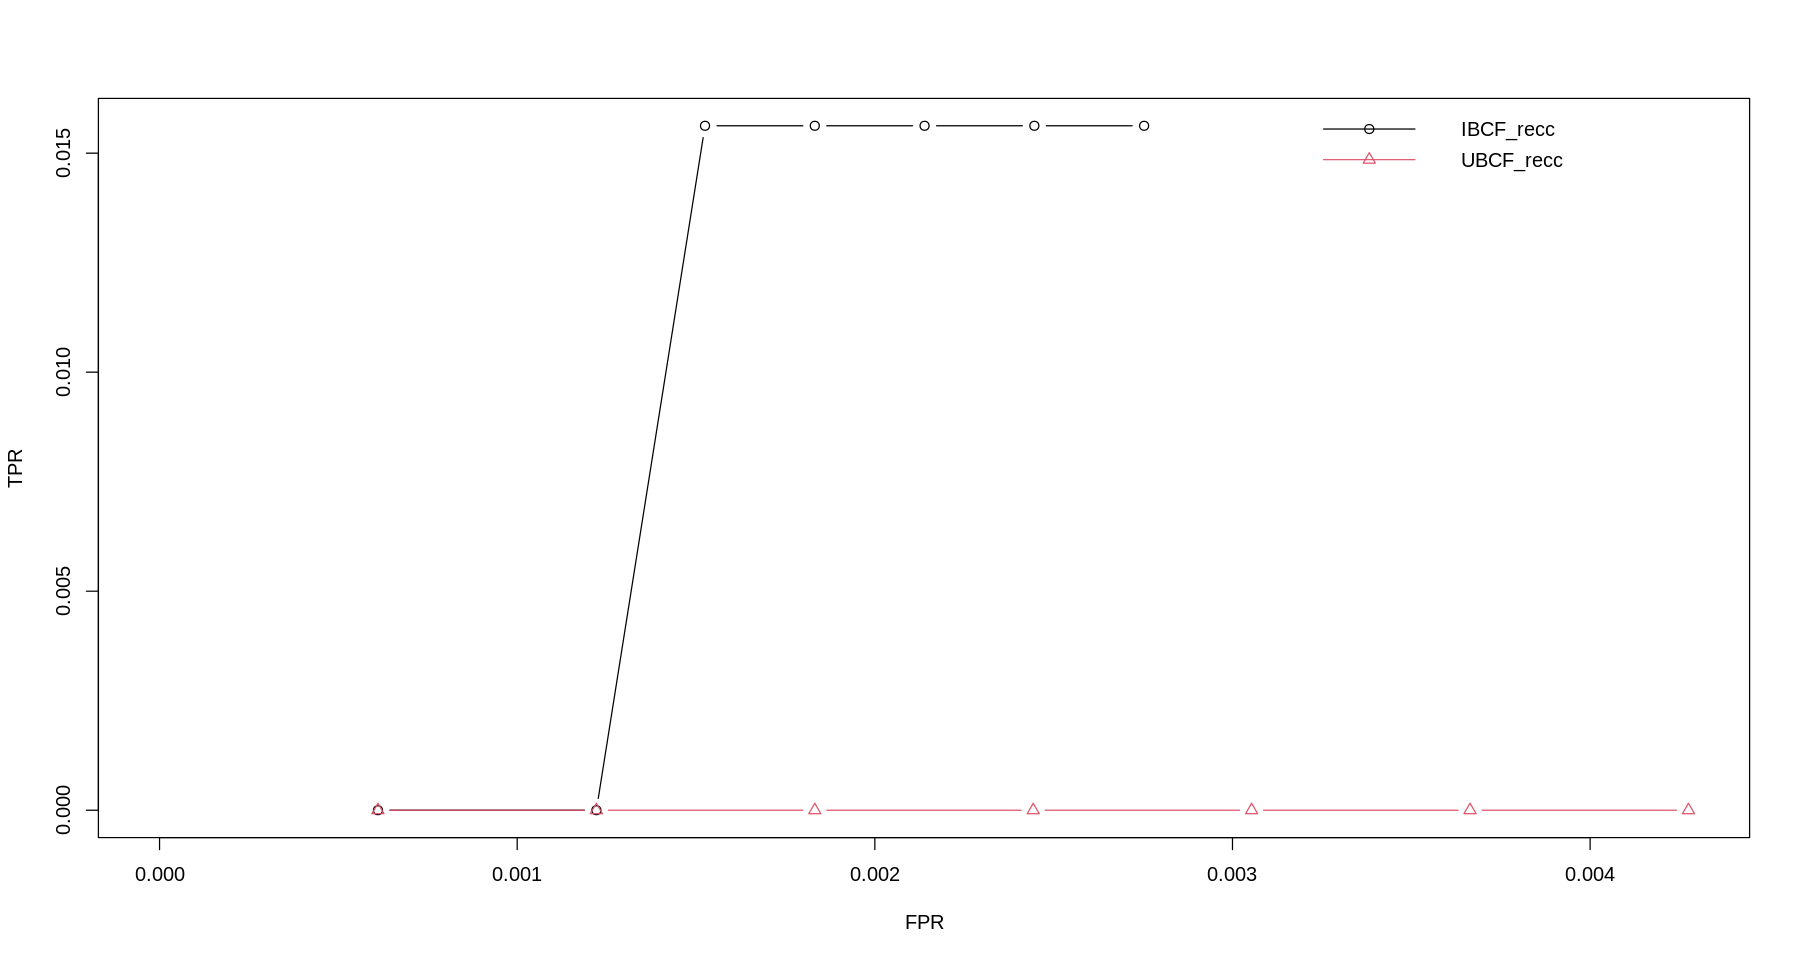

In [ ]:
# plot the results of the evaluation
plot(eval_results, legend="topright")

### Interpretation of Results/ROC

A true positive is achieved if a value of 3 or more was predicted and the user gave a value of 3 or more. A false positive is when a value of 3 or more was given, but the rating was 2 or less.

Although both algorithms perform the quite poorly for the different sizes of number of n (number of movies to predict for the topNList), we can conclude that the item based colaborative filtering model performs better than the user based model, since the area under the curve for the item based model is larger, and the TPR increases from 0 after n=2.


### Trying Different Neighborhood Sizes

In [ ]:
# trying different neighborhood sizes for IBCF
models <- list(
  IBCF_10 = list(name = "IBCF", param = list(k=10)),
  IBCF_20 = list(name = "IBCF", param = list(k=20)),
  IBCF_30 = list(name = "IBCF", param = list(k=30)),
  IBCF_40 = list(name = "IBCF", param = list(k=40)),
  IBCF_50 = list(name = "IBCF", param = list(k=50))
)

In [ ]:
eval_results <- evaluate(x = eval_scheme, type="topNList", method = models, n=1:20)

IBCF run fold/sample [model time/prediction time]
	 1  [0.594sec/0.008sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.551sec/0.007sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.572sec/0.008sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.568sec/0.008sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [0.563sec/0.009sec] 


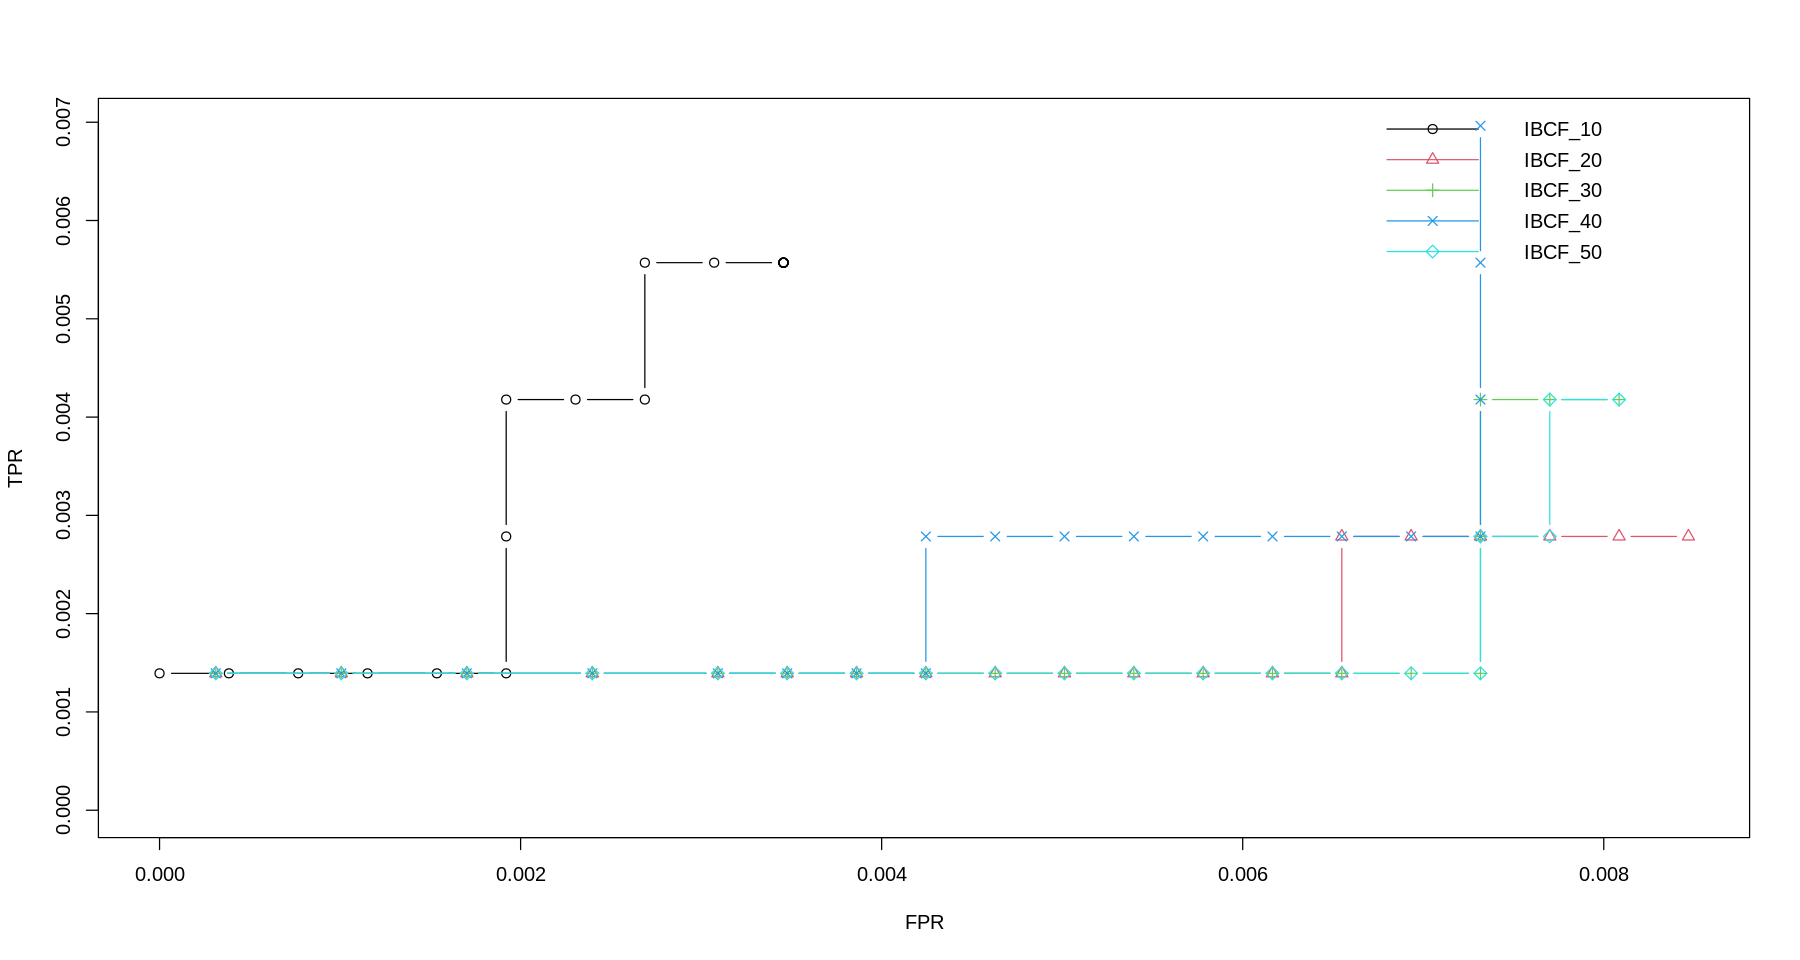

In [ ]:
plot(eval_results, legend="topright")

From the ROC above, the ICBF with a neighborhood size of 10 has the curve closest to the top right corner (which is the most desirable since TPR is high and FPR is low). We can therefore conclude that a neighborhood size of 10 is best out of the sizes tested.